In [ ]:
# Import library yang digunakan
from google.colab import drive
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Menambahkan data dari google drive
# Memasukan path .csv
# Memasukan path image
csv_file_path = '/content/drive/MyDrive/multilabel_modified/multilabel_classification(6)-reduced_modified.csv'
images_path = '/content/drive/MyDrive/multilabel_modified/images'

df = pd.read_csv(csv_file_path)

Found 6355 validated image filenames.
Found 1588 validated image filenames.
Epoch 1/10
198/198 [==============================] - ETA: 0s - loss: 0.2425 - accuracy: 0.8692 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 2997s 15s/step - loss: 0.2425 - accuracy: 0.8692 - val_loss: 0.1099 - val_accuracy: 0.8871
Epoch 2/10
198/198 [==============================] - 822s 4s/step - loss: 0.0396 - accuracy: 0.8947 - val_loss: 0.0678 - val_accuracy: 0.9018
Epoch 3/10
198/198 [==============================] - 836s 4s/step - loss: 0.0282 - accuracy: 0.8906 - val_loss: 0.0722 - val_accuracy: 0.8980
Epoch 4/10
198/198 [==============================] - 856s 4s/step - loss: 0.0230 - accuracy: 0.8923 - val_loss: 0.0773 - val_accuracy: 0.8820
Epoch 5/10
198/198 [==============================] - 857s 4s/step - loss: 0.0208 - accuracy: 0.8977 - val_loss: 0.0797 - val_accuracy: 0.8807
Epoch 6/10
198/198 [==============================] - 877s 4s/step - loss: 0.0183 - accuracy: 0.8980 - val_loss: 0.0799 - val_accuracy: 0.8980
Epoch 7/10
198/198 [==============================] - 877s 4s/step - loss: 0.0170 - accuracy: 0.8985 - val_loss: 0.0753 - val_accuracy: 0.8935
Epoch 8/

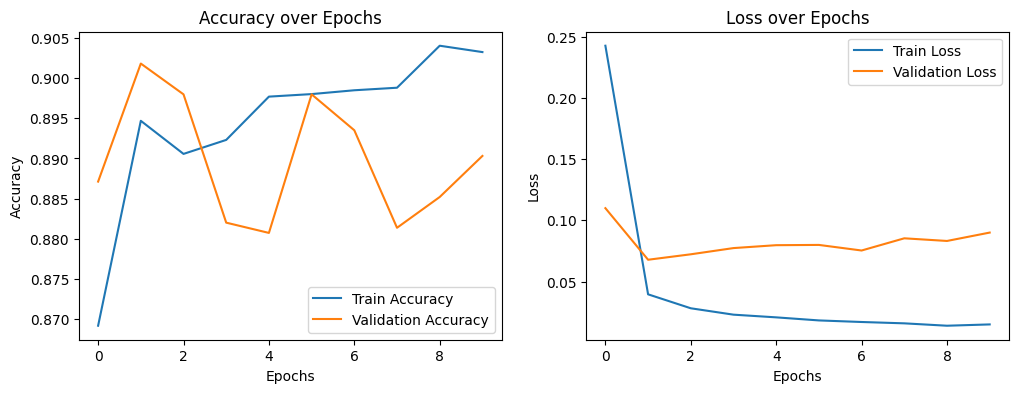

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              23500352  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                      

In [ ]:
# Persiapan data dengan ImageDataGenerator
# Menggunakan 20% data untuk validasi
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=images_path,
    x_col="Image_Name",
    y_col=df.columns[2:].tolist(),
    subset="training",
    class_mode="raw",
    target_size=(128, 128),
    batch_size=32
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=images_path,
    x_col="Image_Name",
    y_col=df.columns[2:].tolist(),
    subset="validation",
    class_mode="raw",
    target_size=(128, 128),
    batch_size=32
)

# Load model pre-trained BiT dari TensorFlow Hub
# BiT memiliki beberapa versi yang bisa dipilih untuk digunakan
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_model = hub.KerasLayer(bit_model_url, trainable=False)

# Membangun model
# Output layer untuk multilabel classification
model = Sequential([
    bit_model,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(df.columns[2:]), activation='sigmoid')
])

# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Menambahkan callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Melatih model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stop]
)

# Plotting hasi berupa accuracy dan loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()

# Rangkuman arsitektur model yang digunakan
model.summary()